<a href="https://colab.research.google.com/github/mccruz07/Goes_CP_ASCL1_promotes_SCRT2_expression_in_the_neural_tube/blob/main/Goes_CP_ASCL1_promotes_SCRT2_expression_in_the_neural_tube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cells Distances to a Line (Neuro tube Center) Analysis in multiple images.

# This Python script analyzes biological imaging data from two CSV files, extracting information about object distances and plotting lines and points based on specific criteria. The code reads two CSV files containing experimental data, processes the information, and calculates distances between objects and a specified line. The results are stored in a DataFrame and saved to a CSV file, both in a default location and a user-specified output folder. The script combines data visualization techniques using Matplotlib and Pandas to provide insights into the spatial relationships each cell to the center of the neuro tube in multiple images.

This notebook requires two files:

file_path1 = '/content/MyExpt_Center.csv' # csv file that contains the x and y coordinates from two points (star and end of the neuro tube) The data structure expected is:

```
ImageNumber - Refers to the image number
ObjectNumber - Object 1 is the start of the line and Object 2 is the end of the line
Location_Center_X - Object X coordinate
Location_Center_Y - Object Y coordinate
Number_Object_Number - Same as ObjectNumber
```



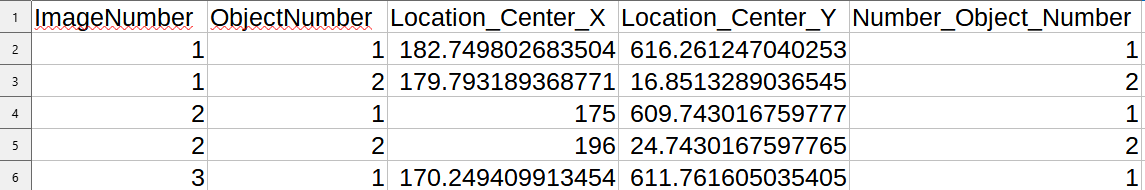

and

file_path2 = '/content/MyExpt_RunCellpose.csv' # csv file that contains the x and y coordinates of each cell of each image.

The data structure expeted is:



```
ImageNumber - Refers to the image number
ObjectNumber - Cell Number
AreaShape_Center_X - Cell X coordinate
AreaShape_Center_Y - Cell Y coordinate
Parent_RelabeledObjects - Refers to each side of the neuro tube the cell is, where 1 is the left side and 2 is the right side of the tube
```




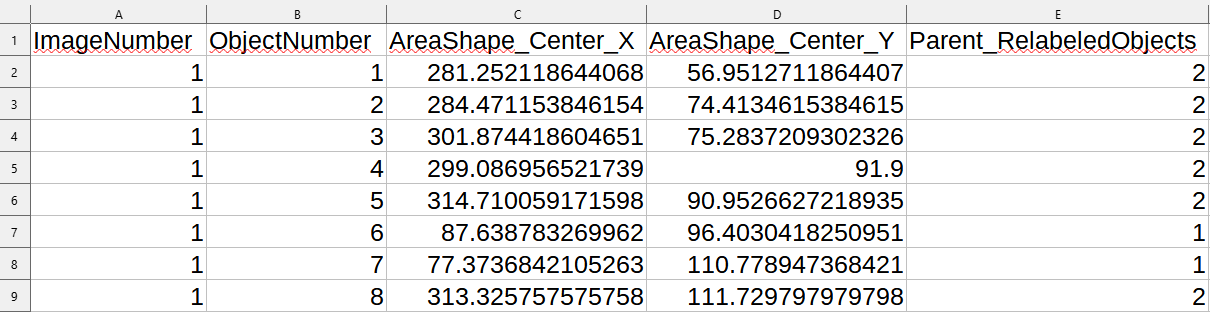

The output of this code are:

results_values.csv - csv file containing the normalized distance of each cell to the center line of the tube.

```
ImageNumber - Refers to the image number
Parent_RelabeledObjects - Refers to each side of the neuro tube the cell is, where 1 is the left side and 2 is the right side of the tube
ObjectNumber - Cell Number
Distance - X coordinate of the cell to the center line
Y_Value - Cell Y coordinate (the values are negative to secure the correct layout of the plots)

```


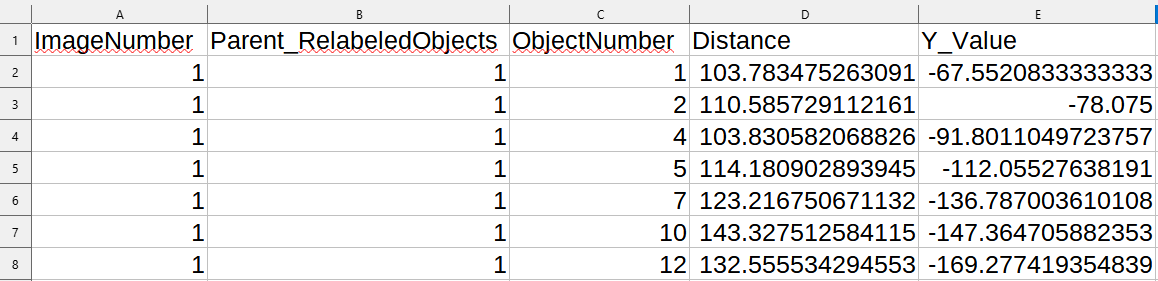

4 plots

Final plot 1 - Scatter plot of each cell from the left side (magenta) and the right side (cyan) of the Neuro Tube.

Final plot 2 - Density plot of the cells from the left side (magenta) and the right side (cyan) of the Neuro Tube.

Final plot 3 - Bar plot of the cell frequency x the distance of the cells from the left side (magenta) and the right side (cyan) of the Neuro Tube.

Final plot 4 - Overlay Bar plot of the cell frequency x the distance of the cells from the left side (magenta) and the right side (cyan) of the Neuro Tube.

In [2]:
# Import necessary libraries
import os               # Library for interacting with the operating system
import numpy as np      # Numerical computing library
import pandas as pd     # Data manipulation and analysis library
import matplotlib.pyplot as plt     # Plotting library
import seaborn as sns   # Data visualization library based on Matplotlib

# Define the output folder path where results will be stored
output_folder = '/content/drive/MyDrive/ResultadosIrene/Cas9_Cas9Sc/'

# Check if the specified folder exists, and create it if not
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

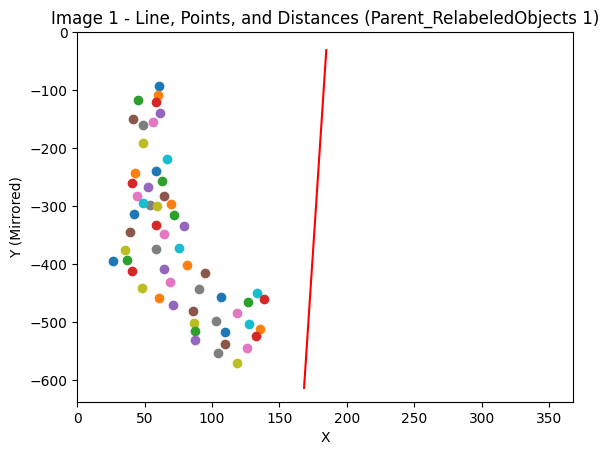

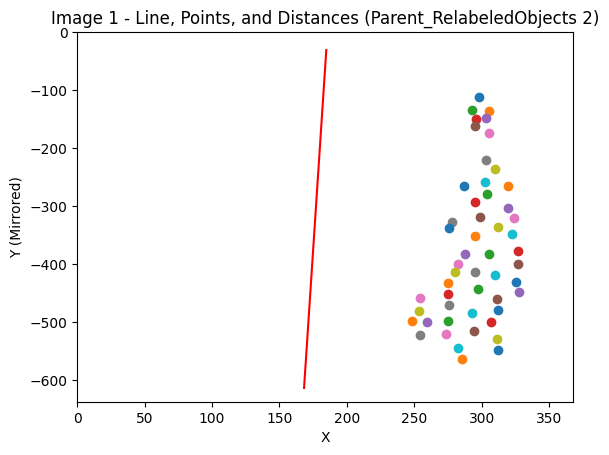

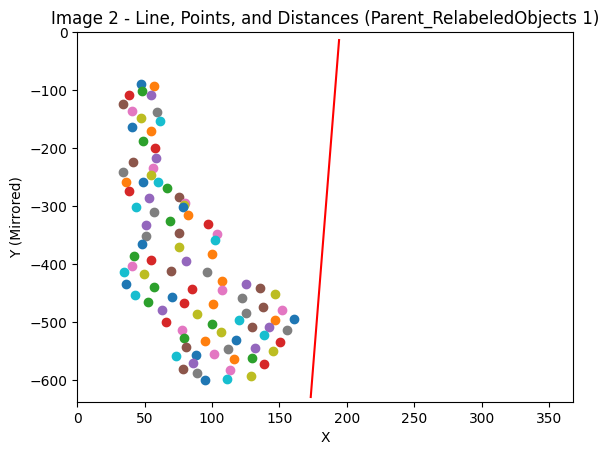

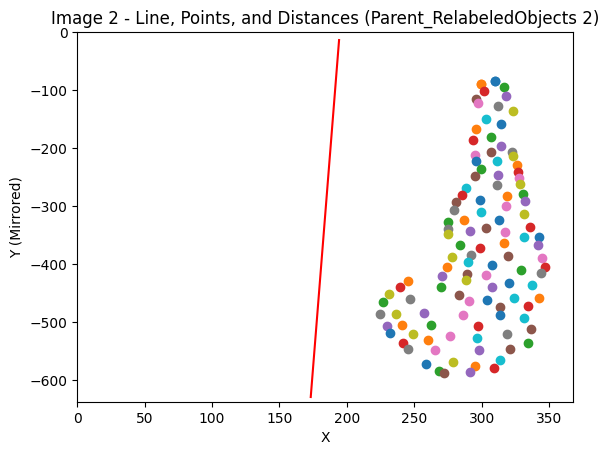

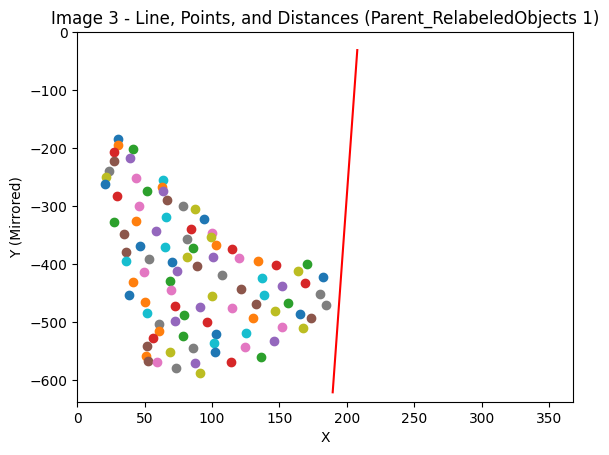

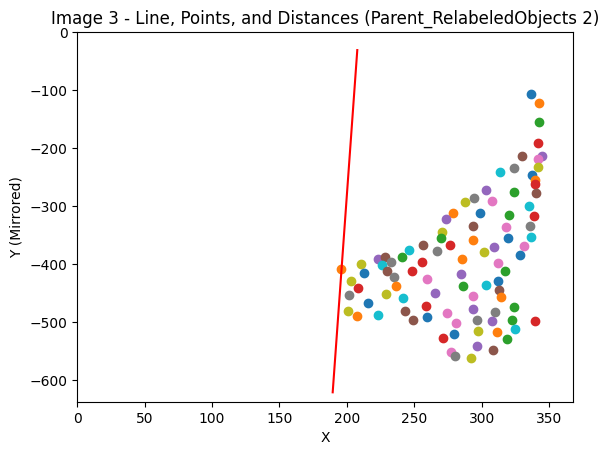

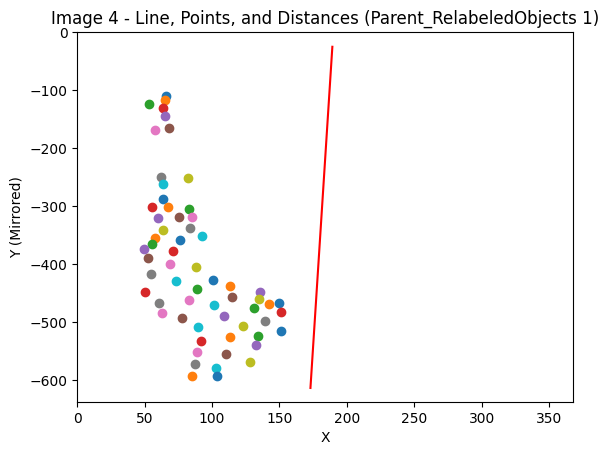

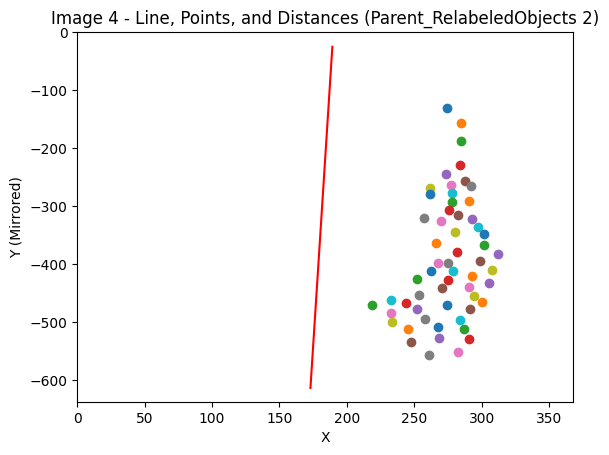

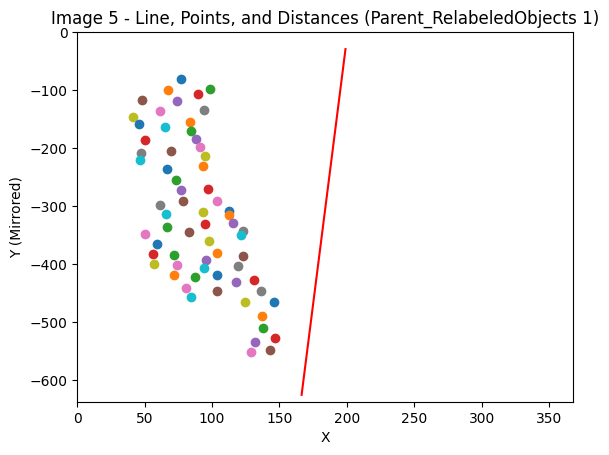

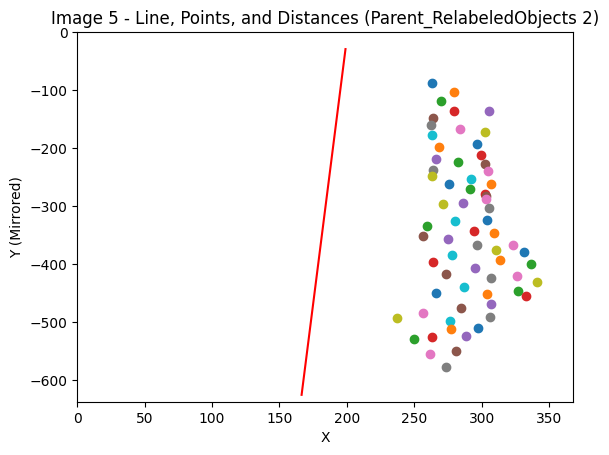

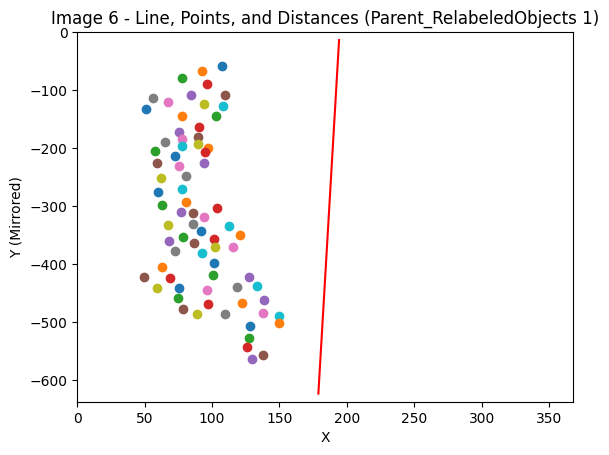

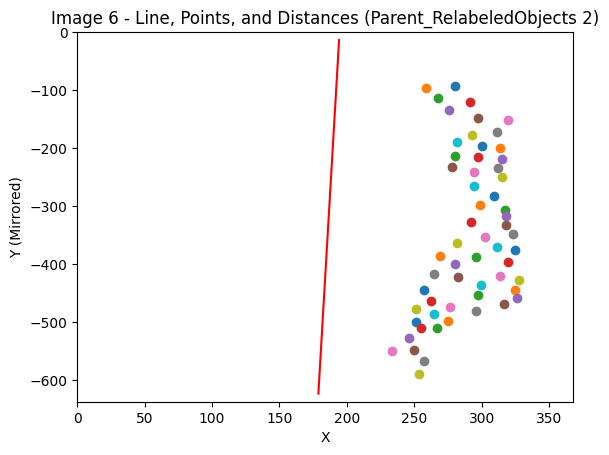

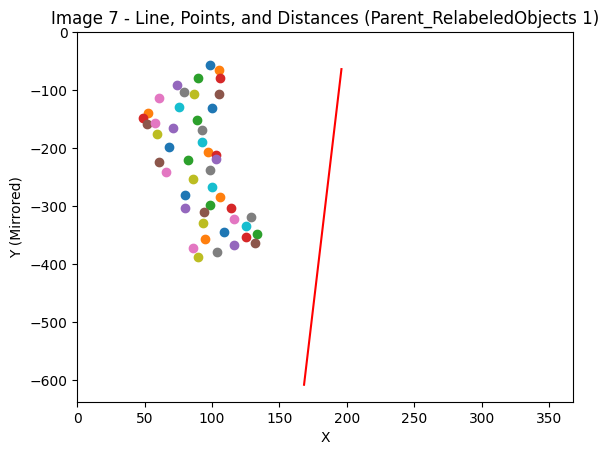

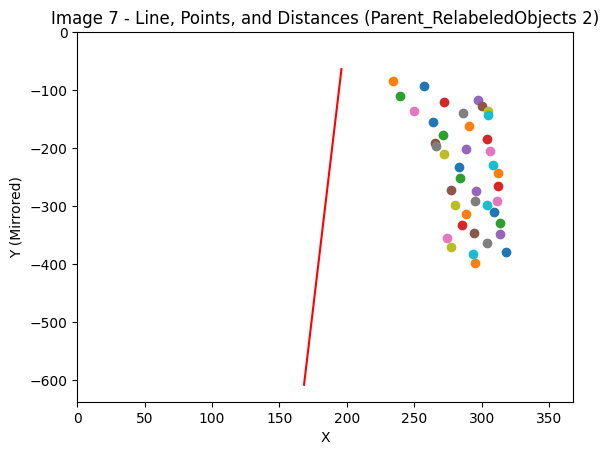

In [ ]:
# Create an empty list to store DataFrames
result_dfs = []

# Read the first CSV file into a DataFrame
file_path1 = '/content/MyExpt_Center.csv'
df1 = pd.read_csv(file_path1)

# Now, let's copy the values and calculate line coordinates for each object in the image number
image_numbers = df1['ImageNumber'].unique()

for image_number in image_numbers:
    image_data = df1[df1['ImageNumber'] == image_number]

    # Initialize line_start and line_end outside the loop
    line_start = None
    line_end = None

    for index, row in image_data.iterrows():
        object_number = row['ObjectNumber']
        center_x = row['Location_Center_X']
        center_y = row['Location_Center_Y']

        # Calculate line coordinates
        if object_number == 1:
            line_start = [center_x, 637 - center_y]  # Mirrored y-coordinate
        elif object_number == 2:
            line_end = [center_x, 637 - center_y]  # Mirrored y-coordinate

    # Check if both line_start and line_end are calculated before plotting
    if line_start is not None and line_end is not None:
        # Load the second CSV file using pandas
        file_path2 = '/content/MyExpt_RunCellpose.csv'
        data = pd.read_csv(file_path2)

        # Filter data based on ImageNumber
        image_data_cells = data[data['ImageNumber'] == image_number]

        # Separate plots based on Parent_RelabeledObjects
        for parent_value, parent_data in image_data_cells.groupby('Parent_RelabeledObjects'):
            # Plot the line with mirrored y-values
            plt.figure()
            plt.plot([line_start[0], line_end[0]], [-line_start[1], -line_end[1]], label='Line', color='red')  # Mirrored y-coordinates

            # Plot points based on ObjectNumber with mirrored y-values
            for obj_number, obj_data in parent_data.groupby('ObjectNumber'):
                plt.scatter(obj_data['AreaShape_Center_X'], -obj_data['AreaShape_Center_Y'], label=f'Object {obj_number}')  # Mirrored y-coordinates

                # Calculate and plot distances
                for _, point_data in obj_data.iterrows():
                    point_x = point_data['AreaShape_Center_X']
                    point_y = point_data['AreaShape_Center_Y']
                    distance = np.abs((line_end[1] - line_start[1]) * point_x - (line_end[0] - line_start[0]) * point_y +
                                      line_end[0] * line_start[1] - line_end[1] * line_start[0]) / np.sqrt(
                        (line_end[1] - line_start[1]) ** 2 + (line_end[0] - line_start[0]) ** 2)

                    # Append information to the list
                    result_dfs.append(pd.DataFrame({
                        'ImageNumber': [image_number],
                        'Parent_RelabeledObjects': [parent_value],
                        'ObjectNumber': [obj_number],
                        'Distance': [distance],
                        'Y_Value': [-point_y]  # Mirrored y-coordinate for distances
                    }))

            plt.title(f'Image {image_number} - Line, Points, and Distances (Parent_RelabeledObjects {parent_value})')
            plt.xlabel('X')
            plt.ylabel('Y (Mirrored)')
            plt.xlim([0, 368])
            plt.ylim([-637, 0])  # Mirrored y-axis limits


# Concatenate all DataFrames in the list
result_df = pd.concat(result_dfs, ignore_index=True)

# Save the result DataFrame to a CSV file
result_df.to_csv('/content/result_values.csv', index=False)


# Save the DataFrame to a CSV file in the specified output folder
result_df.to_csv(output_folder + 'Results_distances.csv', index=False)

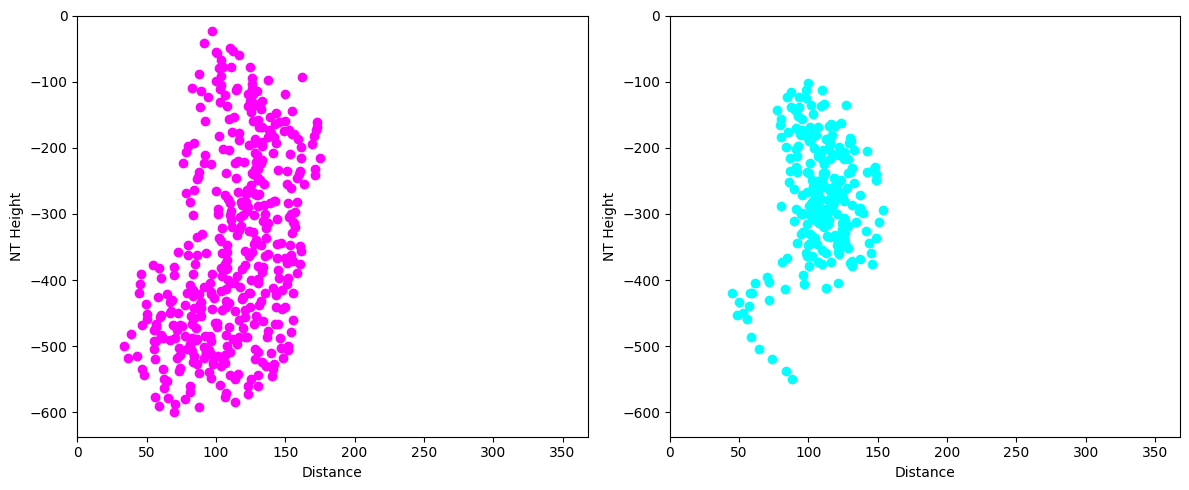

In [4]:
# Read the result_values.csv file into a DataFrame
result_df = pd.read_csv('/content/result_values.csv')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Parent_RelabeledObjects = 1
parent_1_data = result_df[result_df['Parent_RelabeledObjects'] == 1]
axes[0].scatter(parent_1_data['Distance'], parent_1_data['Y_Value'], label='Parent_RelabeledObjects = 1', color='magenta')
#axes[0].set_title('Scatter Plot - Parent_RelabeledObjects = 1')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('NT Height')
#axes[0].legend()
axes[0].set_xlim([0, 368])
axes[0].set_ylim([-637, 0])  # Mirrored y-axis limits

# Plot for Parent_RelabeledObjects = 2
parent_2_data = result_df[result_df['Parent_RelabeledObjects'] == 2]
axes[1].scatter(parent_2_data['Distance'], parent_2_data['Y_Value'], label='Parent_RelabeledObjects = 2', color='cyan')
#axes[1].set_title('Scatter Plot - Parent_RelabeledObjects = 2')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('NT Height')
#axes[1].legend()
axes[1].set_xlim([0, 368])
axes[1].set_ylim([-637, 0])  # Mirrored y-axis limits

# Adjust layout and show the plots
plt.tight_layout()

# Specify the filename for the PDF file (e.g., 'Final_plot1.pdf')
pdf_filename = 'Final_plot1.pdf'

# Combine the output folder and filename to create the full path
pdf_path = f'{output_folder}{pdf_filename}'

# Save the plot as a PDF file
plt.savefig(pdf_path, format='pdf')

plt.show()

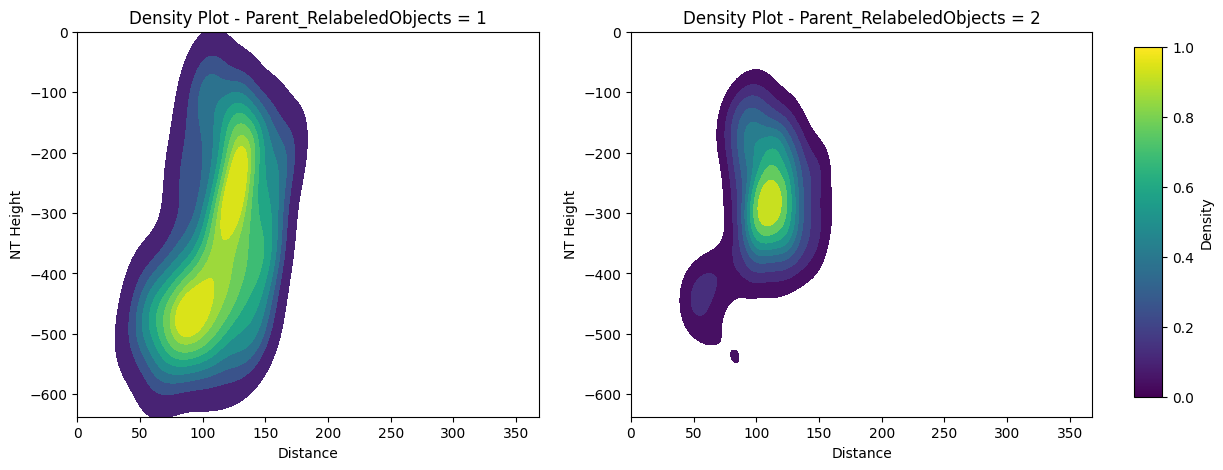

In [5]:
# Read the result_values.csv file into a DataFrame
result_df = pd.read_csv('/content/result_values.csv')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Parent_RelabeledObjects = 1
parent_1_data = result_df[result_df['Parent_RelabeledObjects'] == 1]
sns.kdeplot(data=parent_1_data, x='Distance', y='Y_Value', fill=True, cmap='viridis', ax=axes[0])
axes[0].set_title('Density Plot - Parent_RelabeledObjects = 1')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('NT Height')
axes[0].set_xlim([0, 368])
axes[0].set_ylim([-637, 0])  # Mirrored y-axis limits

# Plot for Parent_RelabeledObjects = 2
parent_2_data = result_df[result_df['Parent_RelabeledObjects'] == 2]
sns.kdeplot(data=parent_2_data, x='Distance', y='Y_Value', fill=True, cmap='viridis', ax=axes[1])
axes[1].set_title('Density Plot - Parent_RelabeledObjects = 2')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('NT Height')
axes[1].set_xlim([0, 368])
axes[1].set_ylim([-637, 0])  # Mirrored y-axis limits

# Adjust layout to make room for the colorbar on the right
plt.subplots_adjust(right=0.85)

# Add colorbar for density to the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = plt.colorbar(axes[1].collections[0], cax=cbar_ax)
cbar.set_label('Density')

# Adjust layout and show the plots
#plt.tight_layout()


# Specify the filename for the PDF file (e.g., 'Final_plot1.pdf')
pdf_filename = 'Final_plot2.pdf'

# Combine the output folder and filename to create the full path
pdf_path = f'{output_folder}{pdf_filename}'

# Save the plot as a PDF file
plt.savefig(pdf_path, format='pdf')

plt.show()


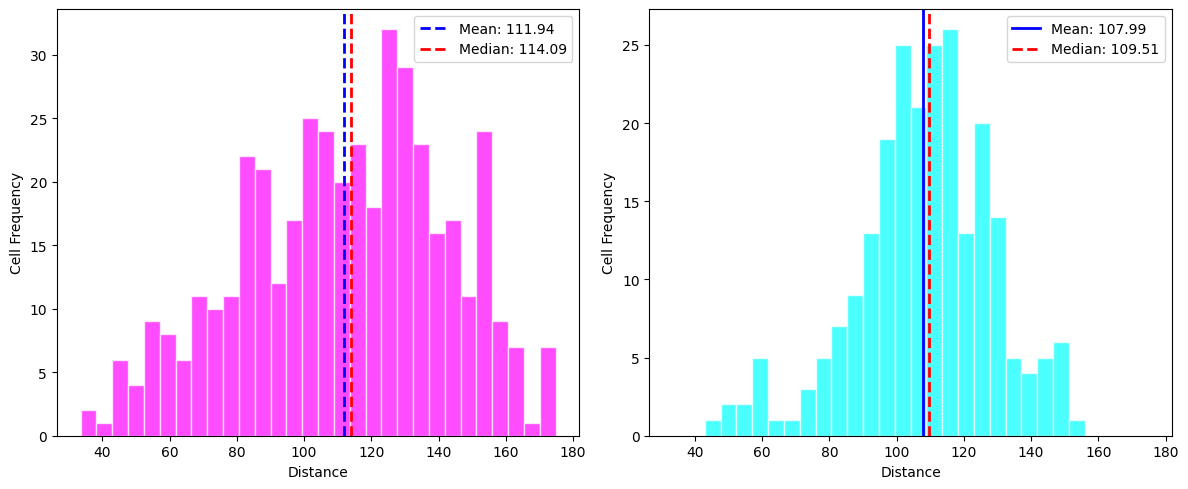

In [7]:
# Read the result_values.csv file into a DataFrame
result_df = pd.read_csv('/content/result_values.csv')

# Determine the common bin range for both histograms
bin_range = (result_df['Distance'].min(), result_df['Distance'].max())

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot histogram for Parent_RelabeledObjects = 1
parent_1_data = result_df[result_df['Parent_RelabeledObjects'] == 1]
axes[0].hist(parent_1_data['Distance'], bins=30, range=bin_range, color='magenta', edgecolor='white', alpha=0.7)
#axes[0].set_title('Histogram - Parent_RelabeledObjects = 1')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Cell Frequency')

# Calculate and display mean and median for Parent_RelabeledObjects = 1
mean_1 = parent_1_data['Distance'].mean()
median_1 = parent_1_data['Distance'].median()
axes[0].axvline(mean_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_1:.2f}')
axes[0].axvline(median_1, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_1:.2f}')
axes[0].legend()

# Plot histogram for Parent_RelabeledObjects = 2
parent_2_data = result_df[result_df['Parent_RelabeledObjects'] == 2]
axes[1].hist(parent_2_data['Distance'], bins=30, range=bin_range, color='cyan', edgecolor='white', alpha=0.7)
#axes[1].set_title('Histogram - Parent_RelabeledObjects = 2')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Cell Frequency')

# Calculate and display mean and median for Parent_RelabeledObjects = 2
mean_2 = parent_2_data['Distance'].mean()
median_2 = parent_2_data['Distance'].median()
axes[1].axvline(mean_2, color='blue', linestyle='solid', linewidth=2, label=f'Mean: {mean_2:.2f}')
axes[1].axvline(median_2, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_2:.2f}')
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()

# Specify the filename for the PDF file (e.g., 'Final_plot1.pdf')
pdf_filename = 'Final_plot3.pdf'

# Combine the output folder and filename to create the full path
pdf_path = f'{output_folder}{pdf_filename}'

# Save the plot as a PDF file
plt.savefig(pdf_path, format='pdf')

plt.show()

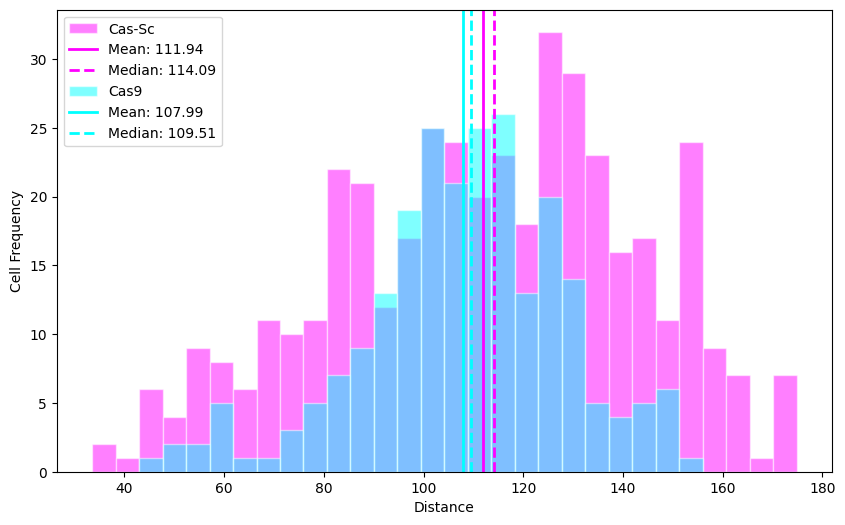

In [8]:
# Read the result_values.csv file into a DataFrame
result_df = pd.read_csv('/content/result_values.csv')

# Determine the common bin range for both histograms
bin_range = (result_df['Distance'].min(), result_df['Distance'].max())

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for Parent_RelabeledObjects = 1
parent_1_data = result_df[result_df['Parent_RelabeledObjects'] == 1]
ax.hist(parent_1_data['Distance'], bins=30, range=bin_range, color='magenta', edgecolor='white', alpha=0.5, label='Left')

# Calculate and display mean and median for Parent_RelabeledObjects = 1
mean_1 = parent_1_data['Distance'].mean()
median_1 = parent_1_data['Distance'].median()
ax.axvline(mean_1, color='magenta', linestyle='solid', linewidth=2, label=f'Mean: {mean_1:.2f}')
ax.axvline(median_1, color='magenta', linestyle='dashed', linewidth=2, label=f'Median: {median_1:.2f}')

# Plot histogram for Parent_RelabeledObjects = 2
parent_2_data = result_df[result_df['Parent_RelabeledObjects'] == 2]
ax.hist(parent_2_data['Distance'], bins=30, range=bin_range, color='cyan', edgecolor='white', alpha=0.5, label='Right')

# Calculate and display mean and median for Parent_RelabeledObjects = 2
mean_2 = parent_2_data['Distance'].mean()
median_2 = parent_2_data['Distance'].median()
ax.axvline(mean_2, color='cyan', linestyle='solid', linewidth=2, label=f'Mean: {mean_2:.2f}')
ax.axvline(median_2, color='cyan', linestyle='dashed', linewidth=2, label=f'Median: {median_2:.2f}')

# Set titles and labels
#ax.set_title('Combined Histograms for Parent_RelabeledObjects 1 and 2')
ax.set_xlabel('Distance')
ax.set_ylabel('Cell Frequency')
ax.legend()

# Specify the filename for the PDF file (e.g., 'Final_plot1.pdf')
pdf_filename = 'Final_plot4.pdf'

# Combine the output folder and filename to create the full path
pdf_path = f'{output_folder}{pdf_filename}'

# Save the plot as a PDF file
plt.savefig(pdf_path, format='pdf')

# Show the plot
plt.show()